<center><h1>Forest Cover Classification</h1></center>
<center><h3>Steps 4 and 5. Model Definition and Training</h3></center>
<center><img src="https://raw.githubusercontent.com/oliver-m-king/forest_cover_classification/main/tree_image.png" alt="Image by Freepik" width="500" height="500"></center>

<h3>The dataset</h3>

This dataset contains observations of a selection of geographic data on 30 x 30 meter cells located in the Roosevelt National Forest of northern Colorado.<br>
There are 581,012 observations of 12 independent variables.<br>
The aim of this project is to develop a model that can accurately predict what type of forest cover a 30m x 30m cell in any area <i>similar</i> to the Roosevelt National Forest has, based on measurements of it's elevation; aspect; distance to water, roads and firepoints; hillshade; and soil type.

Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data.

The dataset was sourced from the <a href="https://archive.ics.uci.edu/ml/datasets/Covertype">Center for Machine Learning and Intelligent Systems, University of California Irvine</a>

<i>Image by Freepik</i>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger


# Define a color list for plotting
color_list = ["#68c4a4", "#ff8c64", "#90a4cc", "#e88cc4", "#ffdc2c", "#a8dc54", "#e8c494"]

# Define directory
data_dir = "C:\\Users\\oliki\\OneDrive\\Forest Cover Classification\\"

<h3>Extract data</h3>

The data is imported from the .pkls outputted in the <i>Feature Engineering</i> phase.

In [2]:
# Import data
file_name = "X.pkl"
X = pd.read_pickle(data_dir + file_name)

file_name = "X_poly.pkl"
poly_X = pd.read_pickle(data_dir + file_name)

file_name = "y.pkl"
y = pd.read_pickle(data_dir + file_name)

<h3>Train test splits</h3>

Train and test splits are created for data both with and without polynomial features. Due to the unbalanced distribution of the the <i>cover_type</i> values a Stratified Shuffle Split is used. The percentage of each of the seven values in each of the splits is saved in a dataframe and displayed to verify that they're the same across splits and for later comparison to predictions made by the models. Differences in the descriptive statistics are also viewed to verify similarity.

In [3]:
# Create train-test splits for data with and without polynomial features
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=123)
for train_index, test_index in sss.split(X, y):
    X_train = X[X.index.isin(train_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[y.index.isin(train_index)]
    y_test = y[y.index.isin(test_index)]
    
for train_index, test_index in sss.split(poly_X, y):
    poly_X_train = poly_X[poly_X.index.isin(train_index)]
    poly_X_test = poly_X[poly_X.index.isin(test_index)]
    poly_y_train = y[y.index.isin(train_index)]
    poly_y_test = y[y.index.isin(test_index)]
    
# Display percentages of each cover type in each y split
split_data = {"y_train":y_train.value_counts().apply(lambda x : round(x / y_train.shape[0], 4)),
              "y_test":y_test.value_counts().apply(lambda x : round(x / y_test.shape[0], 4)),
              "poly_y_train":poly_y_train.value_counts().apply(lambda x : round(x / poly_y_train.shape[0], 4)),
              "poly_y_test":poly_y_test.value_counts().apply(lambda x : round(x / poly_y_test.shape[0], 4))}

split_df = pd.DataFrame(data=split_data)
cover_type_dict = {1:"spruce_fir", 2:"lodgepole_pine", 3:"ponderosa_pine", 4:"cottonwood_willow", 5:"aspen",
                   6:"douglas_fir", 7:"krummholz"}
split_df.rename(index=cover_type_dict, inplace=False)

,y_train,y_test,poly_y_train,poly_y_test
cover_type,,,,
lodgepole_pine,0.4876,0.4876,0.4876,0.4876
spruce_fir,0.3646,0.3646,0.3646,0.3646
ponderosa_pine,0.0615,0.0615,0.0615,0.0615
krummholz,0.0353,0.0353,0.0353,0.0353
douglas_fir,0.0299,0.0299,0.0299,0.0299
aspen,0.0163,0.0163,0.0163,0.0163
cottonwood_willow,0.0047,0.0047,0.0047,0.0047


In [4]:
# Display the differences between the descriptive statistics of the train and test splits
print("Without Polynomial Features")
X_train.describe() - X_test.describe()

Without Polynomial Features


,elevation,slope,hor_dist_to_hydro,ver_dist_to_hydro,hor_dist_to_road,hor_dist_to_fire,hillshade_9am,hillshade_noon,hillshade_3pm,pythag_dist_to_hydro,...,climatic_zone-lower_montane,climatic_zone-montane,climatic_zone-montane_and_subalpine,climatic_zone-montane_dry,climatic_zone-montane_dry_and_montane,climatic_zone-subalpine,geologic_zone-alluvium,geologic_zone-glacial,geologic_zone-igneous_metamorphic,geologic_zone-mixed_sedimentary
count,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,...,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000
mean,-0.000304,0.000339,-0.000130,0.000667,-0.001214,0.001192,0.000586,-0.000839,-0.001122,0.000128,...,0.000315,0.000402,0.000037,-0.000064,0.000060,-0.000658,-0.000586,0.000302,0.000349,-0.000064
std,0.001021,0.001205,-0.001695,0.001397,0.000266,0.001682,-0.002590,0.004928,-0.000270,0.001312,...,0.000574,0.000371,0.000154,-0.001441,0.000929,0.000273,-0.001455,0.000281,-0.000268,-0.001441
min,0.002825,0.000000,0.000000,0.112903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.002825,0.000000,0.000000,0.000000,-0.003150,0.000000,0.000000,0.000000,0.000000,-0.020453,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.002825,0.000000,0.000000,0.000000,-0.001800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.002825,0.000000,0.000000,0.000000,-0.000450,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,-0.111111,-0.025362,-0.048387,0.000450,-0.003277,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
# Create lists for storing F1 scores
model_name_list = []
model_f1_list = []

In [6]:
# Display the differences between the descriptive statistics of the train and test splits
print("With Polynomial Features")
poly_X_train.describe() - poly_X_test.describe()

With Polynomial Features


,elevation,slope,hor_dist_to_hydro,ver_dist_to_hydro,hor_dist_to_road,hor_dist_to_fire,hillshade_9am,hillshade_noon,hillshade_3pm,pythag_dist_to_hydro,...,climatic_zone-montane_dry geologic_zone-igneous_metamorphic,climatic_zone-montane_dry geologic_zone-mixed_sedimentary,climatic_zone-montane_dry_and_montane geologic_zone-alluvium,climatic_zone-montane_dry_and_montane geologic_zone-glacial,climatic_zone-montane_dry_and_montane geologic_zone-igneous_metamorphic,climatic_zone-montane_dry_and_montane geologic_zone-mixed_sedimentary,climatic_zone-subalpine geologic_zone-alluvium,climatic_zone-subalpine geologic_zone-glacial,climatic_zone-subalpine geologic_zone-igneous_metamorphic,climatic_zone-subalpine geologic_zone-mixed_sedimentary
count,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,197544.000000,...,197544.0,197544.000000,197544.000000,197544.0,197544.0,197544.0,197544.000000,197544.000000,197544.000000,197544.0
mean,-0.000304,0.000339,-0.000130,0.000667,-0.001214,0.001192,0.000586,-0.000839,-0.001122,0.000128,...,0.0,-0.000064,0.000060,0.0,0.0,0.0,-0.000304,0.000352,-0.000707,0.0
std,0.001021,0.001205,-0.001695,0.001397,0.000266,0.001682,-0.002590,0.004928,-0.000270,0.001312,...,0.0,-0.001441,0.000929,0.0,0.0,0.0,-0.000938,0.000332,0.000015,0.0
min,0.002825,0.000000,0.000000,0.112903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
25%,-0.002825,0.000000,0.000000,0.000000,-0.003150,0.000000,0.000000,0.000000,0.000000,-0.020453,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
50%,0.002825,0.000000,0.000000,0.000000,-0.001800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
75%,-0.002825,0.000000,0.000000,0.000000,-0.000450,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
max,0.000000,-0.111111,-0.025362,-0.048387,0.000450,-0.003277,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


<h3>Decision Tree</h3>

Decision trees for data with and without polynomial features are fit for depths between 1 and 50. Their resulting F1 scores are plotted to determine which combination of depth and data (with or without polynomial features) achieved the best prediction. The model is then re-fit using that combination of depth and data, and the percentage of each of the seven <i>cover_type</i> values is added to the dataframe created during the Stratified Shuffle Split.

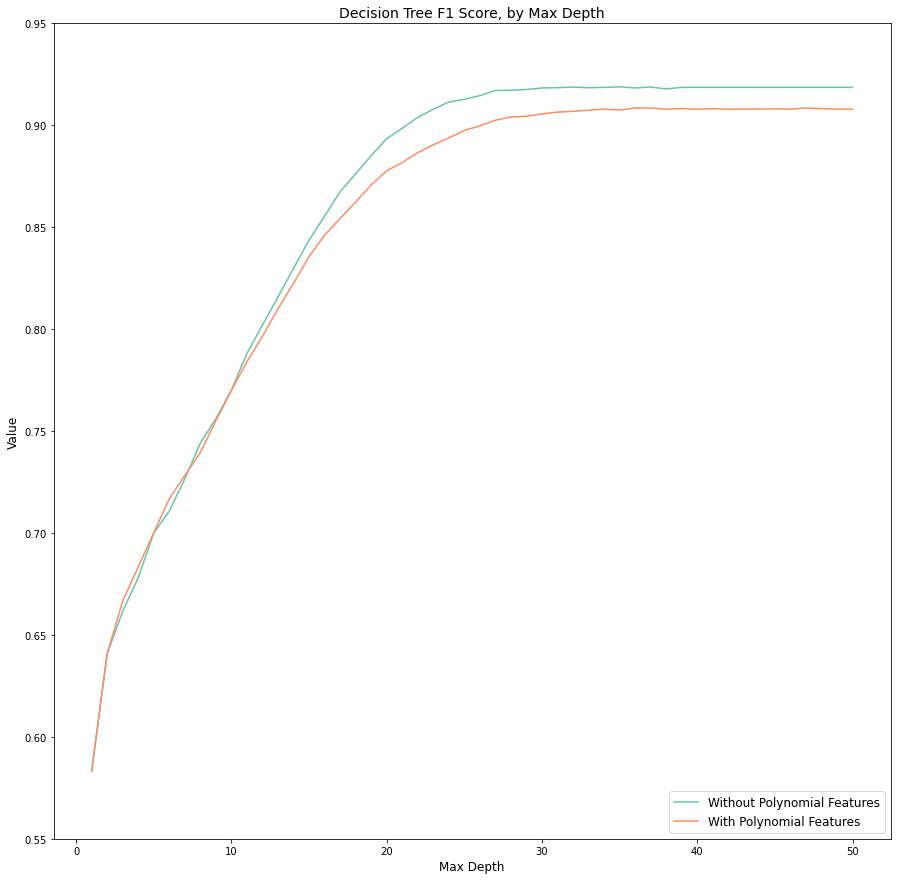

The highest F1 using data without polynomial features is 0.9188963314821109, at a depth of 35
The highest F1 using data with polynomial features is 0.9084891641460883, at a depth of 36


In [7]:
# Decision Tree
X_score_list = []
poly_X_score_list = []
for i in range(50):
    model_dtr = DecisionTreeClassifier(max_depth=i+1, random_state=123)
    
    model_dtr.fit(X_train, y_train)
    y_pred = model_dtr.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="weighted")
    X_score_list.append(f1)
    
    model_dtr.fit(poly_X_train, poly_y_train)
    y_pred = model_dtr.predict(poly_X_test)
    f1 = f1_score(poly_y_test, y_pred, average="weighted")
    poly_X_score_list.append(f1)
    
# Plot F1 scores
plt.rcParams["figure.figsize"] = (15,15)
plt.plot(range(1, 51), X_score_list, color=color_list[0], label = "Without Polynomial Features")
plt.plot(range(1, 51), poly_X_score_list, color=color_list[1], label = "With Polynomial Features")
plt.title("Decision Tree F1 Score, by Max Depth", fontsize=14)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim([0.55, 0.95])
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Print highest F1 scores
max_score = max(X_score_list)
max_score_index = X_score_list.index(max(X_score_list))
print("The highest F1 using data without polynomial features is {}, at a depth of {}".format(max_score, max_score_index + 1))
model_name_list.append("dtr_without_poly")
model_f1_list.append(max_score)

max_score = max(poly_X_score_list)
max_score_index = poly_X_score_list.index(max(poly_X_score_list))
print("The highest F1 using data with polynomial features is {}, at a depth of {}".format(max_score, max_score_index + 1))
model_name_list.append("dtr_with_poly")
model_f1_list.append(max_score)

In [8]:
# Refit the model using the combination of depth and data the resulted in the highest F1 score
model_dtr = DecisionTreeClassifier(max_depth=35, random_state=123)
model_dtr.fit(X_train, y_train)
y_pred = model_dtr.predict(X_test)

# Add percentages of each cover type in predictions to split_df
pred_df = pd.DataFrame(data={"model_dtr":y_pred})
split_df["model_dtr"] = pred_df.value_counts().apply(lambda x : round(x / pred_df.shape[0], 4))
split_df.rename(index=cover_type_dict, inplace=False)

,y_train,y_test,poly_y_train,poly_y_test,model_dtr
cover_type,,,,,
lodgepole_pine,0.4876,0.4876,0.4876,0.4876,0.4877
spruce_fir,0.3646,0.3646,0.3646,0.3646,0.3644
ponderosa_pine,0.0615,0.0615,0.0615,0.0615,0.0619
krummholz,0.0353,0.0353,0.0353,0.0353,0.0354
douglas_fir,0.0299,0.0299,0.0299,0.0299,0.0297
aspen,0.0163,0.0163,0.0163,0.0163,0.0160
cottonwood_willow,0.0047,0.0047,0.0047,0.0047,0.0048


<h3>K-Nearest Neighbours</h3>

K-Nearest Neighbour models for data with and without polynomial features are fit withs Ks of 3, 5, 7, 9, and 11. Their resulting F1 scores are plotted to determine which combination of K and data (with or without polynomial features) achieved the best prediction. The model is then re-fit using that combination of K and data, and the percentage of each of the seven <i>cover_type</i> values is added to the dataframe created during the Stratified Shuffle Split.

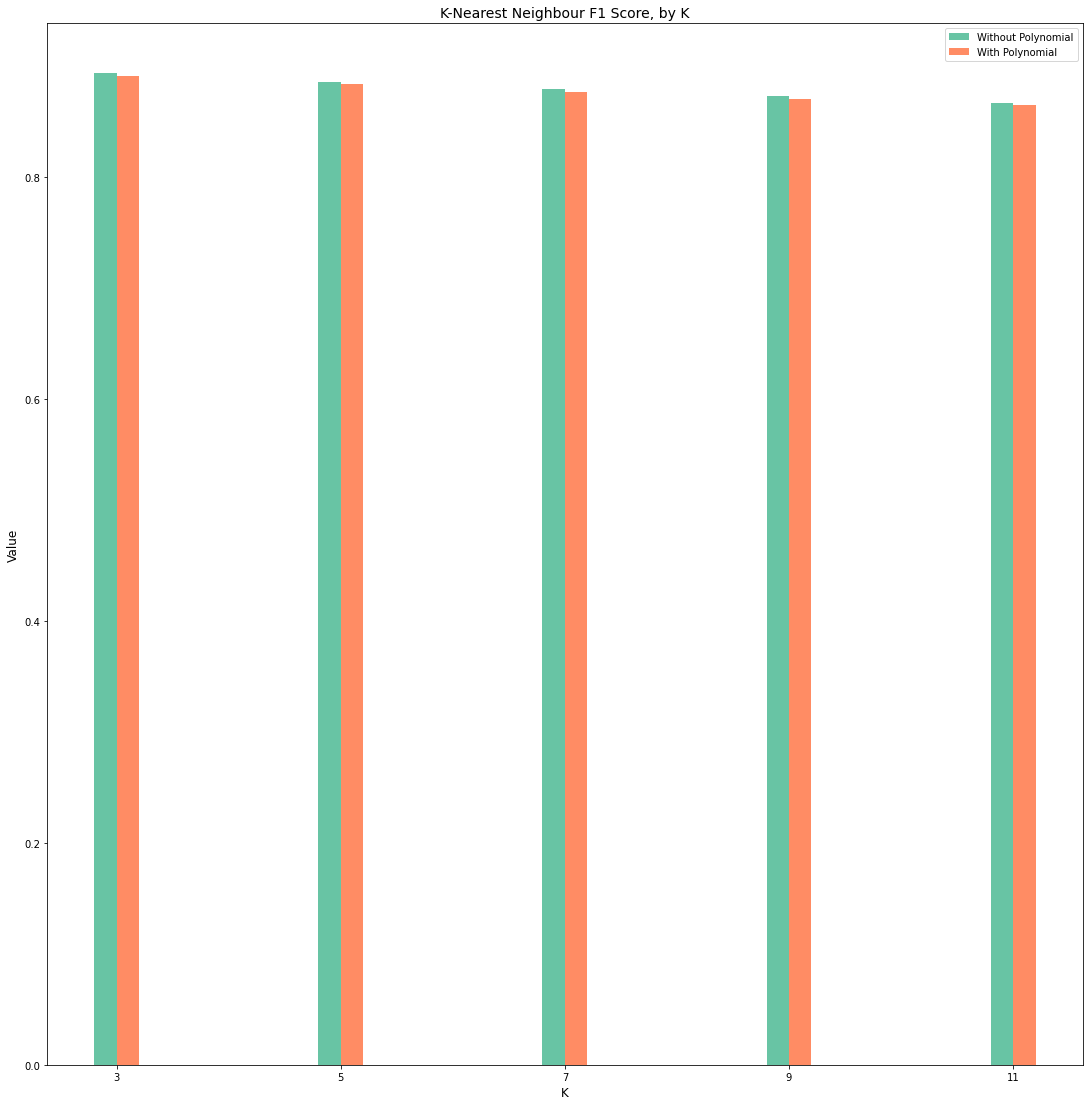

The highest F1 using data without polynomial features is 0.8940544778228586, at a k of 3
The highest F1 using data with polynomial features is 0.8913088847281265, at a k of 3


In [9]:
# K-Nearest Neighbours
X_score_list = []
poly_X_score_list = []
k_list = [3, 5, 7, 9, 11]
for k in k_list:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    
    model_knn.fit(X_train, y_train.values.ravel())
    y_pred = model_knn.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="weighted")
    X_score_list.append(f1)
    
    model_knn.fit(poly_X_train, poly_y_train.values.ravel())
    y_pred = model_knn.predict(poly_X_test)
    f1 = f1_score(poly_y_test, y_pred, average="weighted")
    poly_X_score_list.append(f1)

# Plot F1 scores
fig, ax = plt.subplots(figsize=(15, 15))
ax.bar(np.arange(len(k_list)) - 0.05, X_score_list, 0.1, label="Without Polynomial", color=color_list[0])
ax.bar(np.arange(len(k_list)) + 0.05, poly_X_score_list, 0.1, label="With Polynomial", color=color_list[1])            
fig.tight_layout()
plt.title("K-Nearest Neighbour F1 Score, by K", fontsize=14)
plt.xlabel("K", fontsize=12)
plt.ylabel("Value", fontsize=12)
ax.set_xticks(range(len(k_list)))
ax.set_xticklabels(k_list)
ax.legend()
plt.show()

# Print highest F1 scores
max_score = max(X_score_list)
max_score_index = k_list[X_score_list.index(max(X_score_list))]
print("The highest F1 using data without polynomial features is {}, at a k of {}".format(max_score, max_score_index))
model_name_list.append("knn_without_poly")
model_f1_list.append(max_score)

max_score = max(poly_X_score_list)
max_score_index = k_list[poly_X_score_list.index(max(poly_X_score_list))]
print("The highest F1 using data with polynomial features is {}, at a k of {}".format(max_score, max_score_index))
model_name_list.append("knn_with_poly")
model_f1_list.append(max_score)

In [10]:
# Refit the model using the combination of depth and data the resulted in the highest F1 score
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train.values.ravel())
y_pred = model_knn.predict(X_test)

# Add percentages of each cover type in predictions to split_df
pred_df = pd.DataFrame(data={"model_knn":y_pred})
split_df["model_knn"] = pred_df.value_counts().apply(lambda x : round(x / pred_df.shape[0], 4))
split_df.rename(index=cover_type_dict, inplace=False)

,y_train,y_test,poly_y_train,poly_y_test,model_dtr,model_knn
cover_type,,,,,,
lodgepole_pine,0.4876,0.4876,0.4876,0.4876,0.4877,0.4927
spruce_fir,0.3646,0.3646,0.3646,0.3646,0.3644,0.3638
ponderosa_pine,0.0615,0.0615,0.0615,0.0615,0.0619,0.0618
krummholz,0.0353,0.0353,0.0353,0.0353,0.0354,0.0347
douglas_fir,0.0299,0.0299,0.0299,0.0299,0.0297,0.0284
aspen,0.0163,0.0163,0.0163,0.0163,0.0160,0.0146
cottonwood_willow,0.0047,0.0047,0.0047,0.0047,0.0048,0.0041


<h3>Neural Network</h3>

Neural Networks are designed and trained for 200 epochs on data with and without polynomial features.
The loss, accuracy, precision, and recall are plotted at each epoch, then the trained model is used to predict on the test data and the F1 score is calculated and the percentage of each of the seven <i>cover_type</i> values is added to the dataframe created during the Stratified Shuffle Split.


Predict:

F1 Score:  0.8653455449735319


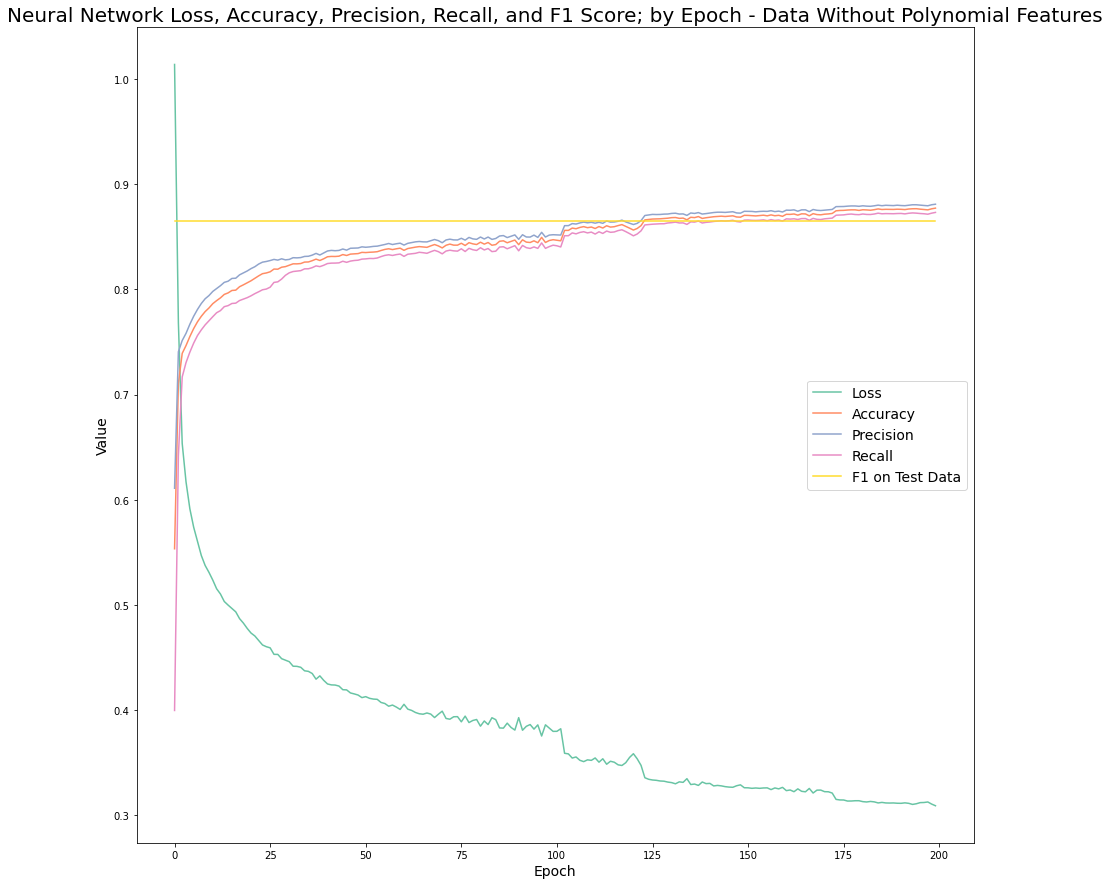

,y_train,y_test,poly_y_train,poly_y_test,model_dtr,model_knn,nn_no_poly
cover_type,,,,,,,
lodgepole_pine,0.4876,0.4876,0.4876,0.4876,0.4877,0.4927,0.4976
spruce_fir,0.3646,0.3646,0.3646,0.3646,0.3644,0.3638,0.3644
ponderosa_pine,0.0615,0.0615,0.0615,0.0615,0.0619,0.0618,0.0614
krummholz,0.0353,0.0353,0.0353,0.0353,0.0354,0.0347,0.0343
douglas_fir,0.0299,0.0299,0.0299,0.0299,0.0297,0.0284,0.0301
aspen,0.0163,0.0163,0.0163,0.0163,0.0160,0.0146,0.0083
cottonwood_willow,0.0047,0.0047,0.0047,0.0047,0.0048,0.0041,0.0040


In [11]:
# Without polynomial features
nn_X = X_train
nn_y = to_categorical(y_train.apply(lambda x : x-1))

num_dense_layers = 32
node_array = np.linspace(nn_X.shape[1], nn_y.shape[1], num_dense_layers)
node_array = np.around(node_array)
dropout_frequency = 16
dropout_rate = 0.075

#model_nn = Sequential()
model_nn.add(Dense(int(node_array[0]), input_shape=(int(node_array[0]),), activation="relu"))
for i in range(num_dense_layers - 2):
    if (i + 1) % dropout_frequency == 0:
        model_nn.add(Dropout(dropout_rate))
    model_nn.add(Dense(int(node_array[i + 1]), activation="relu"))
model_nn.add(Dense(int(node_array[num_dense_layers - 1]), activation="softmax"))

file_name = "epoch_log_no_poly.csv"
model_callbacks = [ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, verbose=0, min_lr=0.0001),
                   CSVLogger(data_dir + file_name, separator=",", append=False)]

model_nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "Precision", "Recall"])
model_history = model_nn.fit(nn_X, nn_y, epochs=200, batch_size=512, verbose=1, callbacks=model_callbacks)

# Predict and get F1
print()
print("Predict:")
y_pred = []
for row in model_nn.predict(X_test):
    row_list = row.tolist()
    max_index = row_list.index(max(row_list))
    y_pred.append(max_index + 1)    

f1 = f1_score(y_test, y_pred, average="weighted")
print()
print("F1 Score: ", f1)

model_name_list.append("nn_without_poly")
model_f1_list.append(f1)

# Plot
plt.rcParams["figure.figsize"] = (20,20)
plt.plot(model_history.history["loss"], color=color_list[0])
plt.plot(model_history.history["accuracy"], color=color_list[1])
plt.plot(model_history.history["precision"], color=color_list[2])
plt.plot(model_history.history["recall"], color=color_list[3])
plt.plot([f1] * len(model_history.history["loss"]), color=color_list[4])
plt.legend(["Loss", "Accuracy", "Precision", "Recall", "F1 on Test Data"], loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt_title = "Neural Network Loss, Accuracy, Precision, Recall, and F1 Score; by Epoch - Data Without Polynomial Features"
plt.title(plt_title, fontsize=20)
plt.show()

# Add percentages of each cover type in predictions to split_df
pred_df = pd.DataFrame(data={"nn_no_poly":y_pred})
split_df["nn_no_poly"] = pred_df.value_counts().apply(lambda x : round(x / pred_df.shape[0], 4))
split_df.rename(index=cover_type_dict, inplace=False)


Predict:

F1 Score:  0.9380719568679573


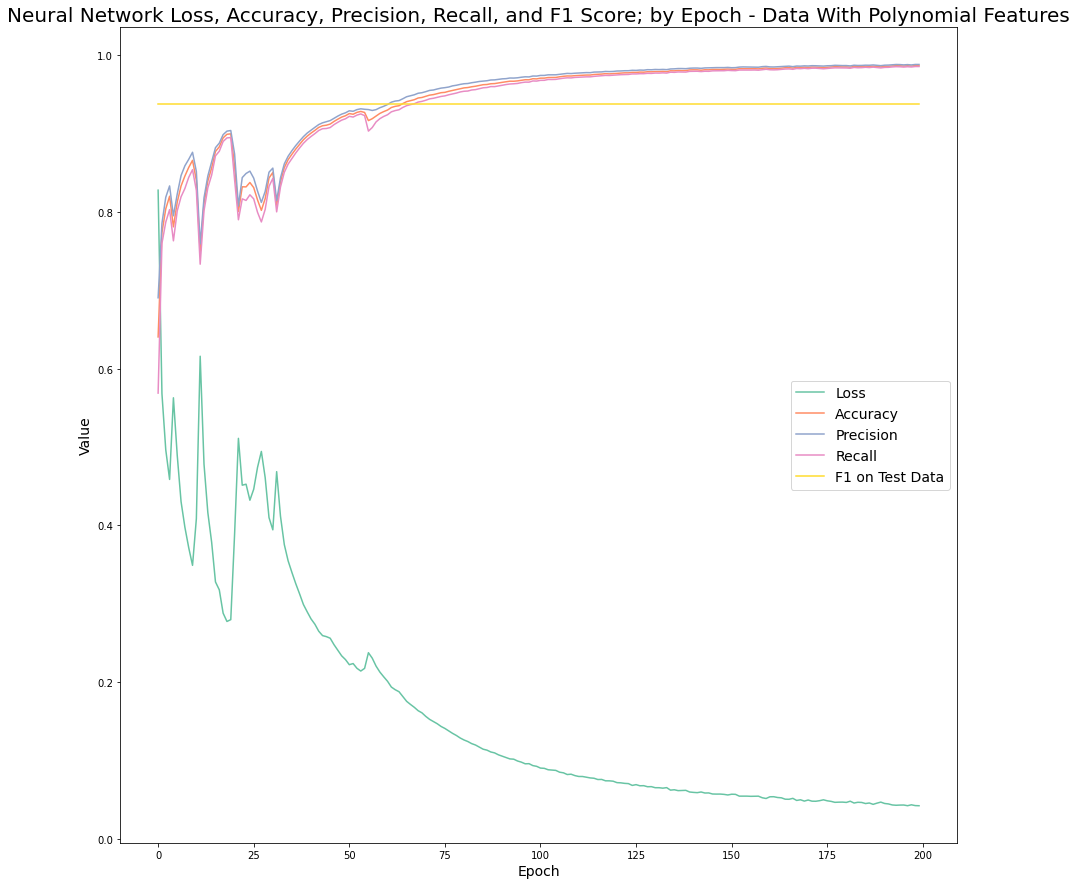

,y_train,y_test,poly_y_train,poly_y_test,model_dtr,model_knn,nn_no_poly,nn_poly
cover_type,,,,,,,,
lodgepole_pine,0.4876,0.4876,0.4876,0.4876,0.4877,0.4927,0.4976,0.4906
spruce_fir,0.3646,0.3646,0.3646,0.3646,0.3644,0.3638,0.3644,0.3642
ponderosa_pine,0.0615,0.0615,0.0615,0.0615,0.0619,0.0618,0.0614,0.0601
krummholz,0.0353,0.0353,0.0353,0.0353,0.0354,0.0347,0.0343,0.0342
douglas_fir,0.0299,0.0299,0.0299,0.0299,0.0297,0.0284,0.0301,0.0303
aspen,0.0163,0.0163,0.0163,0.0163,0.0160,0.0146,0.0083,0.0161
cottonwood_willow,0.0047,0.0047,0.0047,0.0047,0.0048,0.0041,0.0040,0.0044


In [12]:
# With polynomial features
nn_X = poly_X_train
nn_y = to_categorical(poly_y_train.apply(lambda x : x-1))

num_dense_layers = 32
node_array = np.linspace(nn_X.shape[1], nn_y.shape[1], num_dense_layers)
node_array = np.around(node_array)
dropout_frequency = 16
dropout_rate = 0.075

#model_nn = Sequential()
model_nn.add(Dense(int(node_array[0]), input_shape=(int(node_array[0]),), activation="relu"))
for i in range(num_dense_layers - 2):
    if (i + 1) % dropout_frequency == 0:
        model_nn.add(Dropout(dropout_rate))
    model_nn.add(Dense(int(node_array[i + 1]), activation="relu"))
model_nn.add(Dense(int(node_array[num_dense_layers - 1]), activation="softmax"))

file_name = "epoch_log_poly.csv"
model_callbacks = [ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, verbose=0, min_lr=0.0001),
                   CSVLogger(data_dir + file_name, separator=",", append=False)]

model_nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "Precision", "Recall"])
model_history = model_nn.fit(nn_X, nn_y, epochs=200, batch_size=512, verbose=1, callbacks=model_callbacks)

# Predict and get F1
print()
print("Predict:")
y_pred = []
for row in model_nn.predict(poly_X_test):
    row_list = row.tolist()
    max_index = row_list.index(max(row_list))
    y_pred.append(max_index + 1)    

f1 = f1_score(poly_y_test, y_pred, average="weighted")
print()
print("F1 Score: ", f1)

model_name_list.append("nn_with_poly")
model_f1_list.append(f1)

# Plot
plt.rcParams["figure.figsize"] = (20,20)
plt.plot(model_history.history["loss"], color=color_list[0])
plt.plot(model_history.history["accuracy"], color=color_list[1])
plt.plot(model_history.history["precision"], color=color_list[2])
plt.plot(model_history.history["recall"], color=color_list[3])
plt.plot([f1] * len(model_history.history["loss"]), color=color_list[4])
plt.legend(["Loss", "Accuracy", "Precision", "Recall", "F1 on Test Data"], loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt_title = "Neural Network Loss, Accuracy, Precision, Recall, and F1 Score; by Epoch - Data With Polynomial Features"
plt.title(plt_title, fontsize=20)
plt.show()

# Add percentages of each cover type in predictions to split_df
pred_df = pd.DataFrame(data={"nn_poly":y_pred})
split_df["nn_poly"] = pred_df.value_counts().apply(lambda x : round(x / pred_df.shape[0], 4))
split_df.rename(index=cover_type_dict, inplace=False)

<h3>Results</h3>

The F1 scores of each of the models are displayed in descending order. The model that acheived the highest F1 score is saved for use in the <i>Model Evaluation</i> phase.

In [13]:
# Display F1 results
f1_df = pd.DataFrame({"model": model_name_list, "f1_score": model_f1_list})
f1_df.sort_values(by=["f1_score"], ascending=False)

,model,f1_score
5,nn_with_poly,0.938072
0,dtr_without_poly,0.918896
1,dtr_with_poly,0.908489
2,knn_without_poly,0.894054
3,knn_with_poly,0.891309
4,nn_without_poly,0.865346


In [14]:
# Save neaural network with data with polynomial features
file_name = "nn_with_poly"
model_nn.save(data_dir + file_name)

INFO:tensorflow:Assets written to: C:\Users\oliki\OneDrive\Forest Cover Classification\nn_with_poly\assets
